In [7]:
%matplotlib inline

import time
import sys
import os

import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
import scipy

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# ML methods
from sklearn.ensemble import RandomForestClassifier

# Raw data

In [8]:
raw = pandas.read_csv('./KB_data.csv')
raw[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id
0,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),8-16 ft.,POR,2
1,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),16-24 ft.,POR,3


# Feature engineering


In [9]:
# Cross two categorical features into a new one
def feature_cross(data, feature_a, feature_b):
    def cross_value(a, b):
        v = "{}_{} X {}_{}".format(feature_a, a, feature_b, b)
        return v
    
    # possible combinations
    categories = []
    for a_cat in data[feature_a].cat.categories:
        for b_cat in data[feature_b].cat.categories:
            categories.append(cross_value(a_cat, b_cat))
    dtype = pandas.api.types.CategoricalDtype(categories=categories, ordered=False)
    
    def apply_cross(group):
        a,b = group[feature_a], group[feature_b]
        return cross_value(a, b)
        
    crossed = data.apply(apply_cross, axis=1).astype(dtype)
    return crossed

# Discretize distance into bins
def get_distance_class(bins, group):
    distance = group['shot_distance']
    distance_class = len(bins)
    for idx, edge in enumerate(bins[1:]):
        if distance < edge:
            distance_class = idx
            break
    #print('d', distance, distance_class)\n",
    return distance_class

# Fit a cubic spline for distance
def dist_spline_fit(data, start=0, end=32, resolution=2, smooth=0.001):
    dist_bins = numpy.arange(start, end, resolution)
    attempts_by_distance = pandas.cut(data['shot_distance'], dist_bins, right=False)
    grouped = data.groupby(attempts_by_distance)
    accuracy = grouped['shot_made_flag'].mean()
    
    bin_centers = dist_bins[:-1] + 0.5 * (dist_bins[1:] - dist_bins[:-1])
    spline = scipy.interpolate.splrep(bin_centers, accuracy, s=smooth)
    return start, end, spline

def dist_spline_interpolate(s, val):
    start, end, spline = s
    if val > end:
        val = end
    if val < start:
        val = start
    out = scipy.interpolate.splev([val], spline, der=0)
    return out[0]

class FeatureEncoder():

    def __init__(self):
        self.dist_bins = None
        self.dist_spline = None
        self.dist_dtype = None
        
    def fit(self, data):
        q, dist_bins = pandas.qcut(preprocessed['shot_distance'], q=10, duplicates='drop', retbins=True)
        self.dist_bins = dist_bins
        b = list(range(len(dist_bins)+1))
        self.dist_dtype = pandas.api.types.CategoricalDtype(categories=b, ordered=True)

        self.dist_spline = dist_spline_fit(data)
        
    def transform(self, data):
        time_remaining = (data['minutes_remaining'] * 60) + (data['seconds_remaining'])
        last_second = time_remaining < 30 # see quite a lot of desperate shots

        distance_class = data.apply(lambda g: get_distance_class(self.dist_bins, g), axis=1).astype(self.dist_dtype) 
        shot_distance_squared = data['shot_distance'] * data['shot_distance']
        
        injured_season = data['season'].isin(('2013-14', '2014-15', '2015-16'))
        
        shot_type = data['combined_shot_type'].astype('category')
        df = pandas.DataFrame({'type': shot_type, 'dist': distance_class})
        dist_type_cross = feature_cross(df, 'type', 'dist')
        
        dist_est = data['shot_distance'].apply(lambda d: dist_spline_interpolate(self.dist_spline, d))
        
        features = pandas.DataFrame({
            'shot_type': shot_type,

            #'season': data['season'].astype('category'),
            'injured_season': injured_season,
            
            #'opponent': data['opponent'].astype('category'),
            #'playoffs': data['playoffs'].astype('category'),

            'last_second': last_second,
            #'time_remaining': time_remaining,
            #'period': data['period'].astype('category'),
            
            'points': data['shot_type'].astype('category'),

            #'loc_x': data['loc_x'], 
            #'shot_distance': data['shot_distance'],
            'shot_dist_est': dist_est,
            #'shot_distance_squared': shot_distance_squared,
            #'distance_class': distance_class,
            #'dist_type_cross': dist_type_cross,
        })
        
        scaled = set([
            'time_remaining', 'loc_x',
            'shot_distance', 'shot_distance_squared', 'shot_dist_est'
        ]).intersection(features.columns)
        if len(scaled):
            features[list(scaled)] = StandardScaler().fit_transform(features[list(scaled)])
        
        encoded = pandas.get_dummies(features, columns=None, drop_first=True)
        return encoded

preprocessed = raw.copy()

# Tools

In [12]:
# Poor-mans GridSearchCV
def grid_search(estimator, grid, X, Y, splits=100, test_size=0.3, print_progress=True):
    pp = ParameterGrid(grid)
    
    results = []
    
    if print_progress:
        print('%d models with %d splits' % (len(pp), splits))
    
    # Calculate the best hyperparameters
    for model_idx, parameters in enumerate(pp):

        training_accuracies = []
        testing_accuracies = []
        for seed in range(0, splits):
            start_time = time.time()
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
            
            model = estimator(**parameters)
            model.fit(X_train, Y_train)
            
            Y_train_pred = model.predict(X_train)
            Y_test_pred = model.predict(X_test)
            
            train_score = sklearn.metrics.accuracy_score(Y_train, Y_train_pred) 
            test_score = sklearn.metrics.accuracy_score(Y_test, Y_test_pred)
            
            training_accuracies.append(train_score)
            testing_accuracies.append(test_score)
            end_time = time.time()
            if seed == 0:
                sys.stdout.write('\n %d/%d: %.2f(s) ' % (model_idx+1, len(pp), end_time-start_time))
            else:
                sys.stdout.write('.')
        
            confusion = sklearn.metrics.confusion_matrix(Y_test, Y_test_pred)
        
        # TODO: also return variance
        result = {
            'training_accuracy': numpy.average(training_accuracies),
            'testing_accuracy': numpy.average(testing_accuracies),
            'parameters': parameters,
            'confusion': confusion,
        }
        results.append(result)

    # Select best result and retrain model on whole dataset
    by_accuracy = sorted(results, key=lambda r: r['testing_accuracy'], reverse=True)
    best_idx = results.index(by_accuracy[0])
    best_parameters = by_accuracy[0]['parameters']
    model = estimator(**best_parameters)
    model.fit(X, Y)
            
    return model, results, best_idx


def plot_results(res, target=0.616, spread=0.01):
    training = map(lambda r: r['training_accuracy'], res)
    testing = map(lambda r: r['testing_accuracy'], res)
    
    param_names = res[0]['parameters'].keys()
    series = {}
    for name in param_names:
        values = list(map(lambda r: repr(r['parameters'][name]), res))
        series[name] = values
    
    # TODO: plot variance
    # TODO: plot heatmap
    
    series['training_score'] = list(training)
    series['testing_score'] = list(testing)
    
    df = pandas.DataFrame(series)

    # multiline plot with group by 
    def plot_score_trend(group_key, x_key):
        fig, (train_ax, test_ax) = plt.subplots(1, 2, figsize=(16, 6))
        train_ax.set_title("Training score")
        test_ax.set_title("Testing score")
        train_ax.set_xlabel(x_key)
        test_ax.set_xlabel(x_key)
        train_ax.set_ylim(target-spread, target+spread)
        test_ax.set_ylim(target-spread, target+spread)
        test_ax.axhline(y=target, color='black')
        train_ax.axhline(y=target, color='black')
        
        for val, group in df.groupby(group_key):
            label = '{}={}'.format(group_key, val)
            x = [ float(x) for x in group[x_key] ]
            train_ax.plot(list(x), list(group['training_score']), label=label)
            test_ax.plot(list(x), list(group['testing_score']), label=label)

        train_ax.legend()
        test_ax.legend()
        return fig

    first, second = param_names
    fig1 = plot_score_trend(first, second)
    fig2 = plot_score_trend(second, first)

    return fig1, fig2

def plot_forest_importance(forest):
    importances = forest.feature_importances_
    std = numpy.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = numpy.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %d : %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]), )

    # Plot the feature importances of the forest
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title("Feature importances")
    ax.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    #ax.set_xticks(range(X.shape[1]), indices)
    #ax.set_xlim([-1, X.shape[1]])
    return fig

## Model

In [13]:
encoder = FeatureEncoder()
encoder.fit(preprocessed)

usage_set = preprocessed[preprocessed['shot_made_flag'].notnull()]
encoded = encoder.transform(usage_set)
X = encoded
Y = usage_set['shot_made_flag'].astype(numpy.bool)


params = {
    'n_estimators': [ 4, 8, 16, 32 ],
    'min_samples_split': [ 0.1, 0.05, 0.01, 0.005, ],
}
best_model, r, best_idx = grid_search(RandomForestClassifier, params, X, Y, splits=10, print_progress=True)

r[best_idx]

16 models with 10 splits

 1/16: 0.15(s) .........
 2/16: 0.24(s) .........
 3/16: 0.42(s) .........
 4/16: 0.86(s) .........
 5/16: 0.15(s) .........
 6/16: 0.30(s) .........
 7/16: 0.45(s) .........
 8/16: 0.86(s) .........
 9/16: 0.16(s) .........
 10/16: 0.28(s) .........
 11/16: 0.51(s) .........
 12/16: 0.90(s) .........
 13/16: 0.16(s) .........
 14/16: 0.29(s) .........
 15/16: 0.50(s) .........
 16/16: 0.91(s) .........

{'confusion': array([[2988,  475],
        [1893,  854]]),
 'parameters': {'min_samples_split': 0.1, 'n_estimators': 8},
 'testing_accuracy': 0.6139774557165862,
 'training_accuracy': 0.6148132808725064}

(<matplotlib.figure.Figure at 0x7fea1bff0208>,
 <matplotlib.figure.Figure at 0x7fea1bdbc518>)

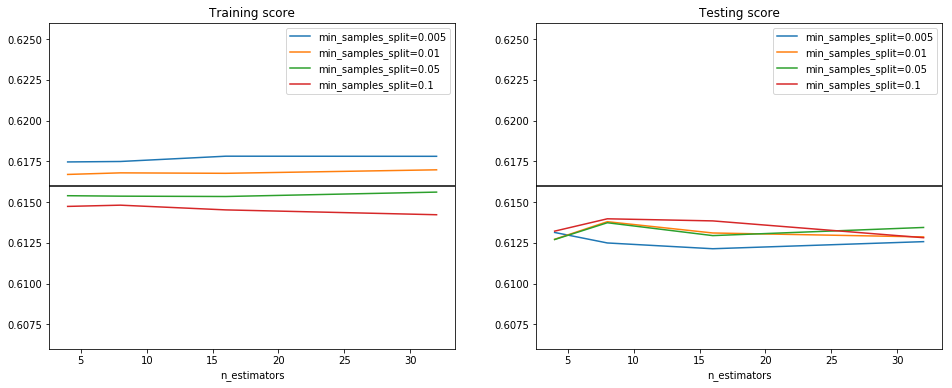

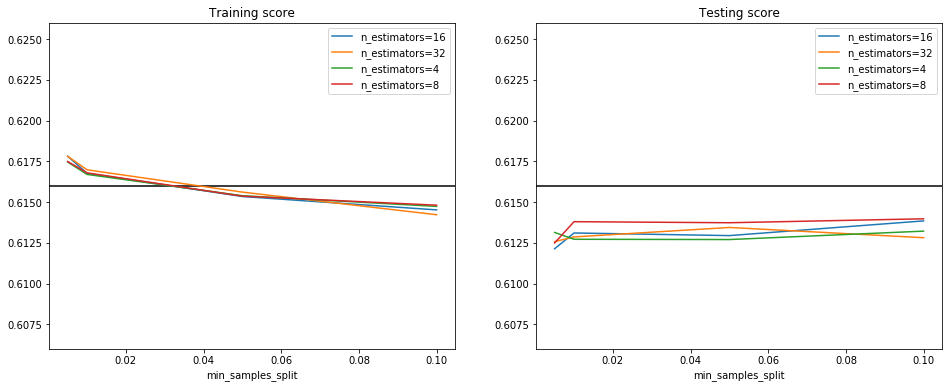

In [14]:
plot_results(r)

Feature ranking:
1. 4 : shot_type_Dunk (0.317364)
2. 6 : shot_type_Jump Shot (0.292173)
3. 2 : shot_dist_est (0.231958)
4. 3 : points_3PT Field Goal (0.058490)
5. 7 : shot_type_Layup (0.047787)
6. 1 : last_second (0.035428)
7. 0 : injured_season (0.009929)
8. 8 : shot_type_Tip Shot (0.004793)
9. 5 : shot_type_Hook Shot (0.002078)


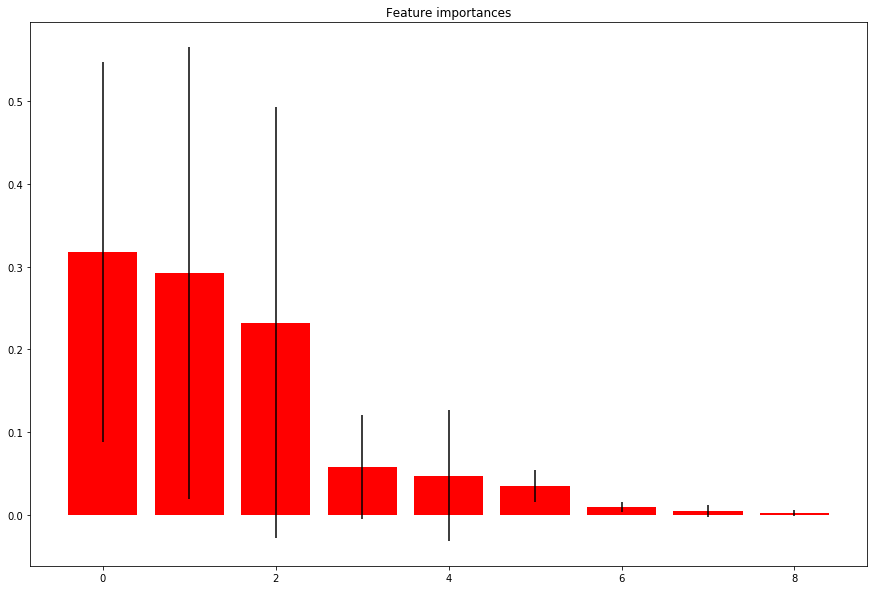

In [15]:
plot_forest_importance(best_model);

## Make Kaggle submission

In [16]:
def make_submission(model, data):
    assert compete_set['shot_id'].shape[0] == 5000, compete_set.shape
    assert compete_set['shot_id'].values[0] == 4
    assert compete_set['shot_id'].values[-1] == 30693
    
    Y_comp = model.predict(data)

    out = compete_set.copy()
    out['shot_made_flag'] = Y_comp.astype(numpy.float)
    out.to_csv('./submission.csv', index=False, columns=['shot_id', 'shot_made_flag'])

compete_set = preprocessed[pandas.isna(preprocessed['shot_made_flag'])]
X_submit = encoder.transform(compete_set)
make_submission(best_model, X_submit)

# Data exploration


### Shot made by distance and type

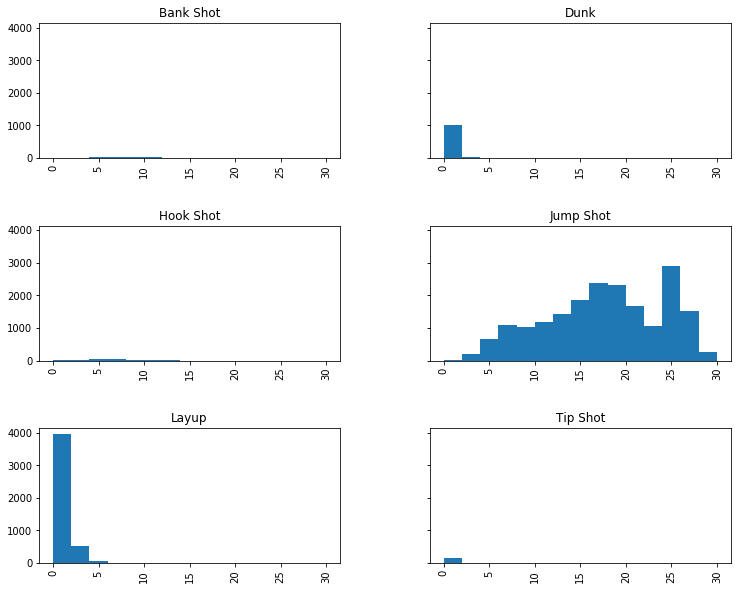

In [74]:
preprocessed.hist(column='shot_distance', by='combined_shot_type',
              bins=15, range=(0.0, 30.0), figsize=(12,10), sharey=True
);

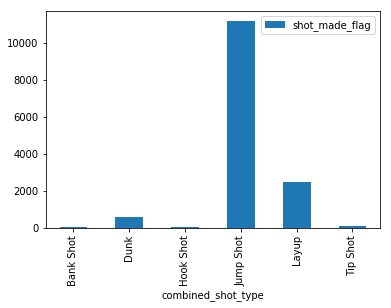

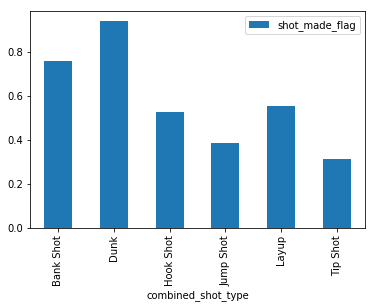

In [169]:
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'count'}).plot(kind='bar')
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

### Shot made by season

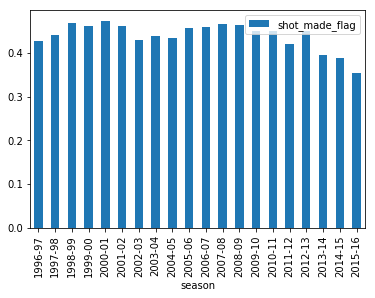

In [76]:
preprocessed.groupby(['season']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [82]:
# Last three seasons worse than the rest, otherwise small variations

### Shot made by oppponent

In [ ]:
preprocessed.groupby(['opponent']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [ ]:
# BKN is an outlier, very few matches

### Shot made by distance

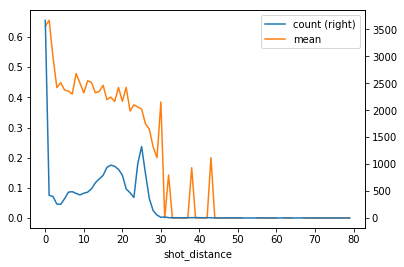

In [75]:
type_by_distance = preprocessed.groupby(['shot_distance'])
count = type_by_distance.agg({'shot_made_flag': 'count'})
mean = type_by_distance.agg({'shot_made_flag': 'mean'})
df = pandas.DataFrame({'count': count['shot_made_flag'], 'mean': mean['shot_made_flag']}, index=count.index)
df.plot(secondary_y='count')

In [180]:
#q, dist_bins = pandas.cut(preprocessed['shot_distance'], bins=30, retbins=True)
#q, dist_bins = pandas.qcut(preprocessed['shot_distance'], q=15, duplicates='drop', retbins=True)
dist_bins.shape, dist_bins 

((16,),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]))

### Estimating a spline for distance

0.4143322281797424 0.4461516161762574


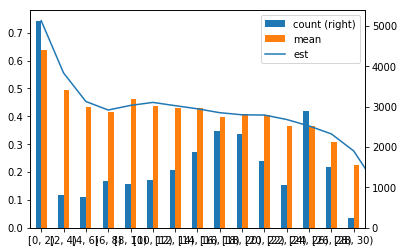

In [214]:
data = preprocessed
#encoded['shot_made_flag'] = data['shot_made_flag']

dist_bins = numpy.arange(0, 32, 2)
attempts_by_distance = pandas.cut(data['shot_distance'], dist_bins, right=False)
grouped = data.groupby(attempts_by_distance)
accuracy = grouped['shot_made_flag'].mean()

s = dist_spline_fit(data)
est = [ dist_spline_interpolate(s, v) for v in numpy.arange(0, 32, 2)]

df = pandas.DataFrame({
    'count': attempts_by_distance.value_counts(),
    'mean': accuracy,
})
ax = df.plot(kind='bar', secondary_y='count')
pandas.DataFrame({"est": est}).plot(ax=ax)

print(accuracy.mean(), data['shot_made_flag'].mean())

### Shot made by period


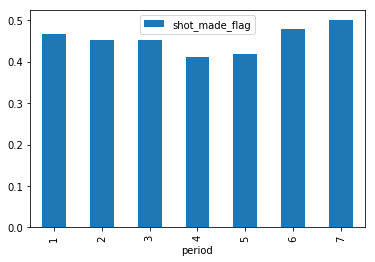

In [81]:
preprocessed.groupby(['period']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

### Shot made by time remaining

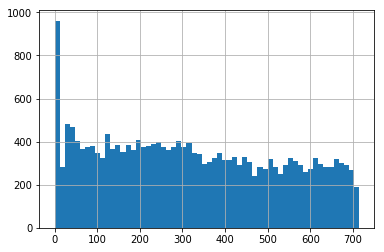

In [118]:
encoded['time_remaining'].hist(bins=60)

In [4]:
time_bins = numpy.arange(0, (60*12)+1, 30)
attempts_in_time = pandas.cut(encoded['time_remaining'], time_bins, right=False)
encoded['shot_made_flag'] = preprocessed['shot_made_flag']
grouped = encoded.groupby(attempts_in_time)
attempts_in_time.value_counts().plot(kind='bar', figsize=(12, 6))
prec = grouped['shot_made_flag'].mean()
acc = prec.plot(kind='bar', figsize=(12, 6), ylim=(0.0, 1.0), title='')

NameError: name 'np' is not defined